# ISLR- Python Ch6 -- Lab 3: PCR and PLS Regression

- [Load Hitters Dataset](#Load-Hitters-Dataset)
- [6.7.1 Principal Component Regression](#6.7.1-Principal-Component-Regression)

In [39]:
# perform standard imports
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score

from matplotlib import pyplot as plt
from operator import itemgetter

%matplotlib inline
plt.style.use('ggplot') # emulate R's pretty plotting

# print numpy arrays with precision 4
np.set_printoptions(precision=4)

## Load Hitters Dataset

In [3]:
# In Lab 1 we explored the hitters dataframe locating rows with missing data and identifying
# categorical variables. See that lab for details...
hitters = pd.read_csv('../../data/Hitters.csv', index_col=0).dropna()

# Create a set of dummy variables for the categoricals
dummies = pd.get_dummies(hitters[['League', 'Division', 'NewLeague']])

# Generate new dataframe with new dummy variables
hitters = hitters.drop(['League', 'Division', 'NewLeague'], axis=1)

# add new dummy variables to hitters
hitters = pd.concat([hitters, dummies[['League_N', 'Division_W', 'NewLeague_N']]],axis=1)

hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,1,0,1
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,1,0,1
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,0,1,0


In [61]:
# Get the predictors and response from hitters
X = hitters.drop('Salary', axis = 1).values
y = hitters.Salary

## 6.7.1 Principal Component Regression

In [118]:
# Lets make sure we understand the terms and how to get them from the sklearn PCA object
# make pca obj
pca = PCA()
# call fit_transform on SCALED X to get the Principal Components
X_pcs = pca.fit_transform(scale(X))
print('The prinipal comoponent matrix has shape (num_samples, num_pcs)=', X_pcs.shape, '\n')
# Print the first two (out of 19 possible) principal components
print('The first two PCs have the following first 5 scores: \n \n', X_pcs[0:5,0:2], '\n')

# The loadings are the 19 coeffecients that project each point onto the Principal Component (eigenvector)
loadings = pca.components_
print('The loadings matrix has shape (num_pcs, num_features) =', loadings.shape, '\n')
print('The 19 loadings for the first two principal components are:\n \n', loadings[:,0:2])

The prinipal comoponent matrix has shape (num_samples, num_pcs)= (263, 19) 

The first two PCs have the following first 5 scores: 
 
 [[-0.0096 -1.8705]
 [ 0.4114  2.4294]
 [ 3.4668 -0.8259]
 [-2.5583  0.231 ]
 [ 1.0277  1.5735]] 

The loadings matrix has shape (num_pcs, num_features) = (19, 19) 

The 19 loadings for the first two principal components are:
 
 [[ 0.1983  0.1959]
 [ 0.3838  0.3773]
 [-0.0886 -0.074 ]
 [ 0.032   0.018 ]
 [-0.0281  0.0047]
 [ 0.0706  0.0822]
 [-0.107  -0.13  ]
 [ 0.2698  0.3887]
 [-0.0122 -0.0616]
 [ 0.1456  0.1305]
 [ 0.0973  0.0144]
 [-0.1031 -0.121 ]
 [ 0.0399 -0.0036]
 [ 0.3062  0.2106]
 [-0.5324  0.0234]
 [ 0.5103 -0.7202]
 [-0.1393  0.1674]
 [ 0.1068 -0.0436]
 [ 0.0538 -0.0978]]


Percent Variance Explained by number of components:

 1     0.383142
2     0.601553
3     0.708417
4     0.790342
5     0.842903
6     0.886348
7     0.922629
8     0.949630
9     0.962827
10    0.972554
11    0.979778
12    0.986487
13    0.991518
14    0.994730
15    0.997466
16    0.998940
17    0.999682
18    0.999938
19    1.000000
dtype: float64


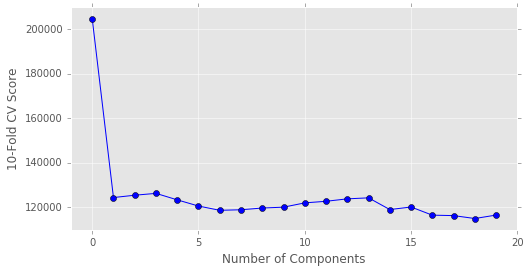

In [149]:
# Now we are ready for PCR...

# Sklearn does not provide direct PC regression. We implement the procedure in a pipeline: 1-scaling, 2-PCA 
# then finally 3-regression.

# list to hold cv scores and explained variances
scores = []
percent_variance = []

# Get number of components and num samples
num_components = list(np.arange(1,X.shape[1]+1))
num_samples = X.shape[0]

# Compute the CV score for no principal components, i.e. perform linear regression with just intercept and get CV
scores.append(-np.mean(cross_val_score(LinearRegression(), np.ones((num_samples,1)), y,
                                        cv=10, scoring = 'mean_squared_error')))
for n in num_components:
    # construct PCA obj with n_components
    pca = PCA(n_components=n)
    
    # apply scaling, PCA, and Linear Regression in a pipeline
    pipeline = Pipeline([('scaler', StandardScaler()), ('pca', pca), ('linear_regression', LinearRegression())])
    
    # Fit data and append cv score
    pipeline.fit(X,y)
    scores.append(-np.mean(cross_val_score(pipeline, X, y, scoring='mean_squared_error', cv=10)))
    percent_variance.append(np.sum(pca.explained_variance_ratio_))

print('Percent Variance Explained by number of components:\n\n', pd.Series(percent_variance, index=range(1,20)))

# Plot CV scores across number of PCs   
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(scores, marker='o', color='b');
ax.set_xlabel('Number of Components');
ax.set_ylabel('10-Fold CV Score');
ax.set_xlim(xmin=-1);

We find that 18 of the 19 components leads to the smallest Test MSE using 10-fold CV.

### We will now use the validation set approach to get the Test MSE

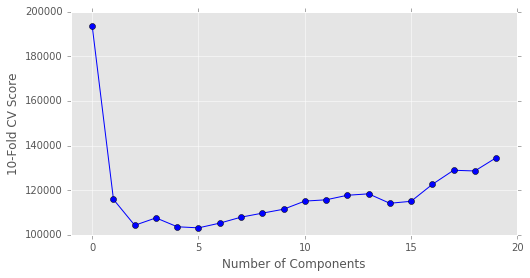

In [156]:
np.random.seed(2)
# split the data into test and validation sets
train = np.random.choice([True, False], size=len(hitters))

X_train = X[train]
y_train = y[train]
X_test = X[~train]
y_test = y[~train]

num_samples = X_train.shape[0]

# list to hold cv scores
scores = []

# Get number of components and num samples of training data
num_components = list(np.arange(1,X_train.shape[1]+1))
num_samples = X_train.shape[0]

# Compute the CV score for no principal components, i.e. perform linear regression with just intercept and get CV
scores.append(-np.mean(cross_val_score(LinearRegression(), np.ones((num_samples,1)), y_train,
                                        cv=10, scoring = 'mean_squared_error')))
for n in num_components:
    # construct PCA obj with n_components
    pca = PCA(n_components=n)
    
    # apply scaling, PCA, and Linear Regression in a pipeline
    pipeline = Pipeline([('scaler', StandardScaler()), ('pca', pca), ('linear_regression', LinearRegression())])
    
    # Fit data and append cv score
    pipeline.fit(X_train,y_train)
    scores.append(-np.mean(cross_val_score(pipeline, X_train, y_train, scoring='mean_squared_error', cv=10)))

# Plot CV scores across number of PCs   
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(scores, marker='o', color='b');
ax.set_xlabel('Number of Components');
ax.set_ylabel('10-Fold CV Score');
ax.set_xlim(xmin=-1);

So 5 components give the lowest test error rate. Now apply a 5 component model to predict test set error rate.

In [152]:
# Set the number of components to 5 and call predict method of Linear Regression in our pipeline
pca = PCA(n_components=5)
y_predict = pipeline.predict(X_test) 

MSE = np.mean((y_predict-y_test)**2)
print(MSE)

93264.4849178
